# Mario map
### Trying to auto generate mario-like maps

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import random

In [2]:
map_tif_path = glob.glob("map_data/gm_lc_v3/*.tif")
im_full = [Image.open(path) for path in map_tif_path]

/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (933120000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [30]:
scale_1 = 2
im_full_scaled = [im.resize((int(im.size[0]/scale_1),int(im.size[1]/scale_1)),
                                resample = PIL.Image.NEAREST) for im in im_full]

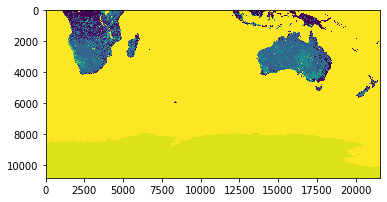

In [31]:
plt.imshow(im_full_scaled[3])
plt.show()

In [5]:
im_full_scaled

[<PIL.Image.Image image mode=L size=4320x2160 at 0x109421AC8>,
 <PIL.Image.Image image mode=L size=4320x2160 at 0x109421B00>,
 <PIL.Image.Image image mode=L size=4320x2160 at 0x109421B70>,
 <PIL.Image.Image image mode=L size=4320x2160 at 0x109421BA8>]

In [32]:
[im_full_scaled[i].size for i in range(4)]

[(21600, 10800), (21600, 10800), (21600, 10800), (21600, 10800)]

In [7]:
im_full_scaled[0].info

{'compression': 'tiff_lzw', 'dpi': (1, 1), 'resolution': (1, 1)}

In [33]:
im = Image.new("L", (im_full_scaled[0].size[0]*2,im_full_scaled[0].size[1]*2))
width = im_full_scaled[1].size[0]
height = im_full_scaled[1].size[1]
im.paste(im_full_scaled[0],(0,0))
im.paste(im_full_scaled[1],(width,0))
im.paste(im_full_scaled[2],(0,height))
im.paste(im_full_scaled[3],(width,height))
im_master = im

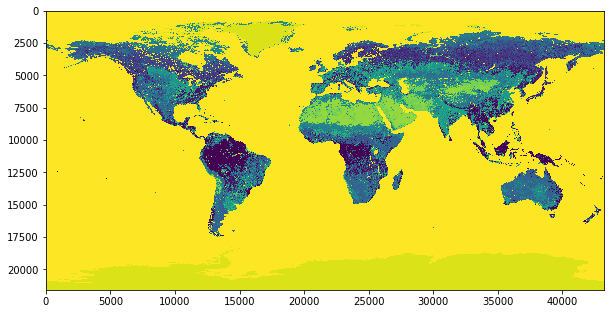

In [34]:
fig = plt.figure(figsize = (10,20))
plt.imshow(im_master, aspect = "equal")
plt.show()

/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (138000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


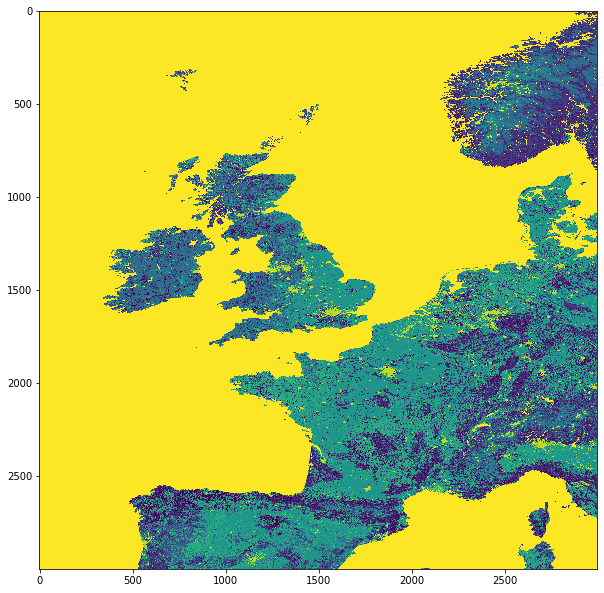

In [43]:
fig = plt.figure(figsize = (10,20))
im = im_master.crop((20000,3000,23000,6000))
plt.imshow(im, aspect = "equal")
plt.show()

In [92]:
data = np.array(im)
data = np.flip(data, axis = 1)
data = data.swapaxes(0,1)
data = np.flip(data, axis = 0)

In [44]:
im.size

(3000, 3000)

### Now to get mario sprites

sprites/zanzio.png


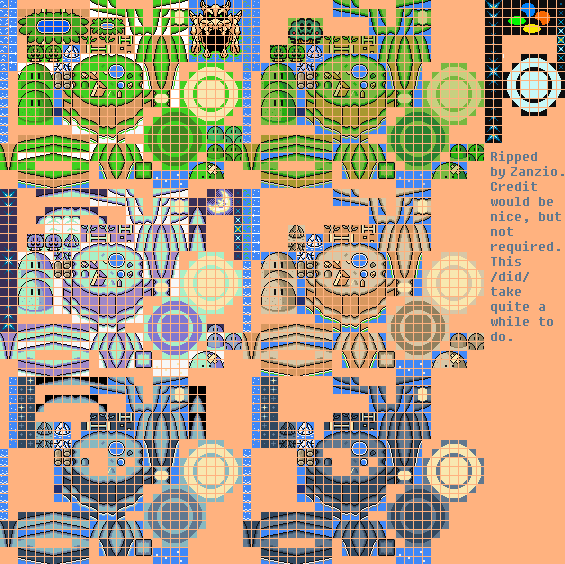

In [232]:
tile_sheet_path = glob.glob("sprites/*")[0]
print(tile_sheet_path)
tile_sheet = Image.open(tile_sheet_path)
tile_sheet

In [236]:
def get_sprite_small(x, y, tile_sheet = tile_sheet):
    l = x * 9
    u = y * 9
    r = l + 8
    d = u + 8
    return tile_sheet.crop((l,u,r,d))

def get_sprite(x, y, w = 1, h = 1, tile_sheet = tile_sheet):
    if w == 1 and h == 1:
        return get_sprite_small(x,y, tile_sheet)
    im = Image.new("RGBA", (w * 8, h * 8))
    for i in range(w):
        for j in range(h):
            s = get_sprite_small(x + i,y + j,tile_sheet)
            im.paste(s, (i*8,j*8))
    return im

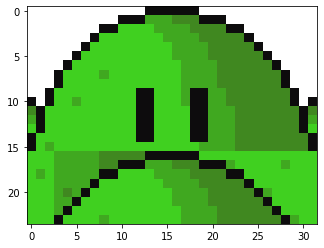

In [237]:
plt.imshow(get_sprite(2,7, h = 3, w = 4))
plt.show()

### Nice: sprites are loaded
### Now to NOT USE PYGAME
#### Using Image class as a canvas instead....

In [212]:
tiles_x = 100
tiles_y = int(tiles_x * im.size[1] / im.size[0])
canvas = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))

In [213]:
canvas.paste((68,139,244),(0,0,canvas.size[0], canvas.size[1]))

In [242]:
# def draw_sprite(canvas, sprite, t_x, t_y):
#     canvas.paste(sprite, (t_x*8, t_y * 8))
#     return canvas

def draw_sprite(canvas, sprite, t_x, t_y):
    canvas.paste(sprite, (t_x*8, t_y * 8), mask = sprite)
    return canvas



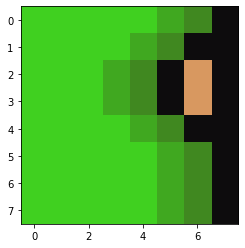

In [215]:
plt.imshow(get_sprite(15,8, h = 1, w = 1))
plt.show()

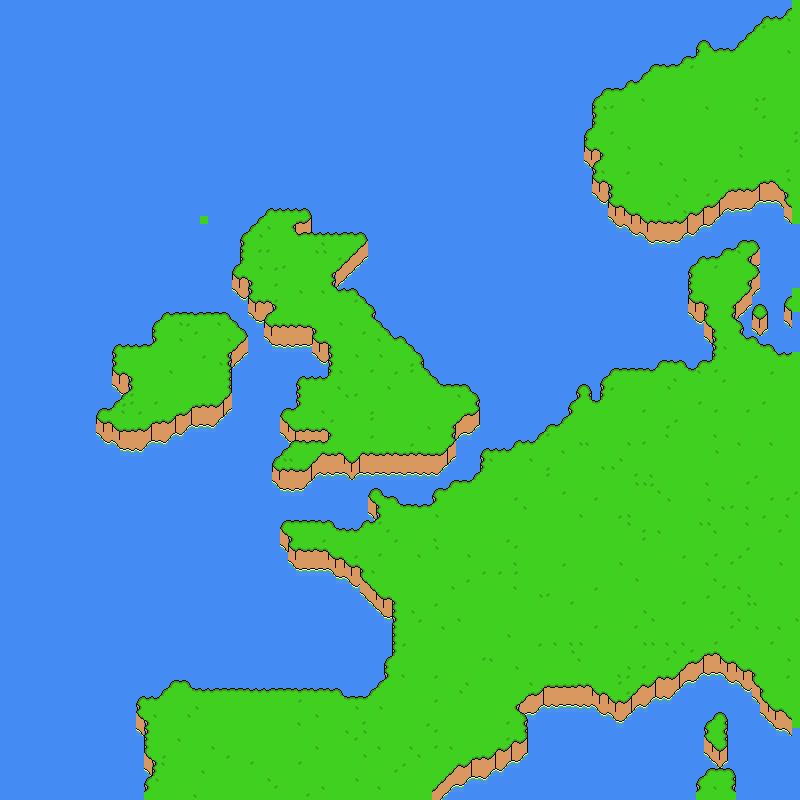

In [246]:
from scipy.ndimage import gaussian_filter as gf

dataPixPerTile = int(im.size[0]/tiles_x) #Very approx, avoid

canvas.paste((68,139,244),(0,0,canvas.size[0], canvas.size[1]))

def t2x(tx): #Convert tile coords to map coords
    return int(tx * im.size[0]/tiles_x)
def t2y(ty):
    return int(ty * im.size[0]/tiles_x)

def rand_rot(im):
    n = random.choice([0,1,2,3])
    return im.rotate(90 * n)


#Get all tiles that are land
land = np.full((tiles_x, tiles_y), False)
for tx in range(tiles_x):
    for ty in range(tiles_y):
        d = data[t2x(tx):t2x(tx+1),t2y(ty):t2y(ty+1)]
        if (d == 20).mean() < 0.5:
            land[tx,ty] = True
land = gf(land.astype(float), 0.7) > 0.5 #Smooth a lil
#Smooth more:
for tx in range(tiles_x):
    for ty in range(tiles_y):
        if land[tx,ty] == False: continue
        #At edge
        if tx == 0 or ty == 0 or tx == tiles_x - 1 or ty == tiles_y - 1:
            draw_grass(canvas, tx, ty)
            continue
        u = land[tx,ty - 1]
        d = land[tx,ty +1]
        l = land[tx -1, ty]
        r = land[tx + 1, ty]
        if (not (l or r)) or (not (u or d)):
            land[tx,ty] = 0 



            
def draw_grass(canvas, tx,ty):
    grass_sprites = [get_sprite(10,7), get_sprite(11,7)]
    s = random.choices(grass_sprites, [10,1])[0]
    s = rand_rot(s)
    draw_sprite(canvas, s,tx,ty)
    
#Make ocean pretty
land_gf = gf(land.astype(float), 5)
for tx in range(tiles_x):
    for ty in range(tiles_y):
        if land[tx,ty] == True: continue
        if random.random() < land_gf[tx,ty]: continue
        wave_sprites = [get_sprite(0,0),get_sprite(0,1),get_sprite(0,2)]
        s = random.choice(wave_sprites)
        s = wave_sprites[0]
#         draw_sprite(canvas, s,tx,ty)
        
#Draw green ground
for tx in range(tiles_x):
    for ty in range(tiles_y):
        if land[tx,ty] == False: continue
        #At edge
        if tx == 0 or ty == 0 or tx == tiles_x - 1 or ty == tiles_y - 1:
            draw_grass(canvas, tx, ty)
            continue
        u = land[tx,ty - 1]
        d = land[tx,ty +1]
        l = land[tx -1, ty]
        r = land[tx + 1, ty]
        ul = land[tx -1, ty - 1]
        ur = land[tx +1, ty - 1]
        dl = land[tx -1, ty + 1]
        dr = land[tx +1, ty + 1]
        
        
#         draw_grass(canvas, tx, ty)
#         continue
        
        if d == False:
            if l and r:
                #Horizontal continue
                draw_sprite(canvas, random.choice([get_sprite(11,11), get_sprite(12,11)]), tx, ty)
                draw_sprite(canvas, get_sprite(10,12), tx, ty+1)
                draw_sprite(canvas, get_sprite(10,12), tx, ty+2)
                draw_sprite(canvas, random.choice([get_sprite(11,15), get_sprite(12,15)]), tx, ty+3)
            elif not dl and not dr and l and not r:
                #Begin up right
                draw_sprite(canvas, get_sprite(15,10), tx, ty)
                draw_sprite(canvas, get_sprite(12,12), tx, ty+1)
                draw_sprite(canvas, get_sprite(15,13), tx, ty+2)
            elif not dl and not dr and not l and r:
                #Begin up left
                draw_sprite(canvas, get_sprite(8,10), tx, ty)
                draw_sprite(canvas, get_sprite(11,12), tx, ty+1)
                draw_sprite(canvas, get_sprite(8,13), tx, ty+2)
            elif dl and l and not r:
                #Continue up right
                draw_sprite(canvas, get_sprite(16,10), tx, ty)
                draw_sprite(canvas, get_sprite(10,12), tx, ty+1)
                draw_sprite(canvas, get_sprite(15,13), tx, ty+2)
            elif dr and r and not l:
                #Continue up left
                draw_sprite(canvas, get_sprite(7,10), tx, ty)
                draw_sprite(canvas, get_sprite(10,12), tx, ty+1)
                draw_sprite(canvas, get_sprite(8,13), tx, ty+2)
            else:
                draw_grass(canvas, tx, ty)
        #Side panels
        elif u and not r:
            draw_sprite(canvas, random.choice((get_sprite(15,9),get_sprite(15,8))), tx, ty)
        elif u and not l:
            draw_sprite(canvas, random.choice((get_sprite(8,9),get_sprite(8,8))), tx, ty)
        #Top panels
        elif d and not u:
            if l and r:
                #Horizontal continue
                draw_sprite(canvas, random.choice([get_sprite(11,6), get_sprite(12,6)]), tx, ty)
            elif l and not r:
                #Begin up right
                draw_sprite(canvas, get_sprite(15,7), tx, ty)
            elif  not l and r:
                #Begin up left
                draw_sprite(canvas, get_sprite(8,7), tx, ty)
            elif ul and l and not r:
                #Continue up right
                draw_sprite(canvas, get_sprite(16,10), tx, ty)
            elif ur and r and not l:
                #Continue up left
                draw_sprite(canvas, get_sprite(7,10), tx, ty)
            else:
                draw_grass(canvas, tx, ty)
            
        else:
            draw_grass(canvas, tx, ty)
            
canvas